In [15]:
# Poisson Regression Model for forecasting counts
# Regression is used to explain the functional relationship b/w the response
# variable and the predictor variable.
# Overdispersion - variance is greater than mean

# Aim - (COUNT BASED DATA)
# -------------------------------------------------------------------------------
# To model the HIV Cases in Bangkok using Poisson and Negative Binomial
# Distribution. No of HIV Cases will be modelled based on the predictor
# variables that influence it.

# Assumption - there is a certain rate of occurrence of events λ that drives
# the generation of such data. The event rate may drift over time.
# So λ is no of events per unit time.

# -------------------------------------------------------------------------------
# Case 1 - If λ is constant / 5 cases per unit time or per day
# Poisson Regression model for a constant λ
# -------------------------------------------------------------------------------

# -------------------------------------------------------------------------------
# Case 2 - # Real World situation
# λ can change from 1 situation to another i.e. value of λ
# is influenced by a vector of explanatory variables, also known as
# predictors, regression variables, or regressors or matrix of regression
# variables, X.
# -------------------------------------------------------------------------------

#  Build a Poisson regression model for the observed HIV Recent Infection counts y.


In [16]:
# Step 1 Import libraries
# --------------------------------------------------------------
import pandas as pd
import os
import patsy
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [3]:
# Step 2 Check wd and read file
# --------------------------------------------------------------
wd = os.getcwd()
print(wd)
os.chdir('/Users/sylviachadha/Desktop/Study/All_datasets')

df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])


/Users/sylviachadha/Desktop/Tools/PyCharm/hivproject_2020/models


In [18]:
# Step 3 Add some more features to dataset
# --------------------------------------------------------------
# Convert df index to series and extract columns Month, Day etc
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day


In [19]:
# Step 4 Create train and test dataset
# --------------------------------------------------------------
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))


Training data set length=175
Testing data set length=39


In [20]:
# # Step 5 Patsy notation (describing statistical models in pythpn)
# --------------------------------------------------------------

expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""


In [21]:
#  Step 6 Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
print("y_train", y_train.head())
print("X_train", X_train.head())



y_train             BB_COUNT
Date                
2017-04-02    2021.0
2017-04-03    2470.0
2017-04-05    2807.0
2017-04-07    1222.0
2017-04-08    1674.0
X_train             Intercept  DAY  DAY_OF_WEEK  MONTH  HIGH_T  LOW_T  PRECIP
Date                                                                 
2017-04-02        1.0  2.0          6.0    4.0    62.1   41.0    0.00
2017-04-03        1.0  3.0          0.0    4.0    63.0   50.0    0.03
2017-04-05        1.0  5.0          2.0    4.0    63.0   46.0    0.00
2017-04-07        1.0  7.0          4.0    4.0    48.0   43.0    0.01
2017-04-08        1.0  8.0          5.0    4.0    55.9   39.9    0.00


In [22]:
# Step 7 Using the statsmodels GLM class, train the Poisson regression model
# on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# Print the training summary.
print(poisson_training_results.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  175
Model:                            GLM   Df Residuals:                      168
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12002.
Date:                Thu, 04 Mar 2021   Deviance:                       22312.
Time:                        06:38:31   Pearson chi2:                 2.21e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0630      0.013    558.796      

In [23]:
# Step 8 Predictions and results on test data
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)


                   mean    mean_se  mean_ci_lower  mean_ci_upper
Date                                                            
2017-04-01  1900.778035  11.201971    1878.948890    1922.860785
2017-04-04   900.325910   8.170584     884.453440     916.483229
2017-04-06  1206.649309   7.994090    1191.082467    1222.419602
2017-04-13  2571.749428   8.612097    2554.925300    2588.684342
2017-04-15  2404.316198   8.131530    2388.431398    2420.306643
2017-04-17  2779.491802  10.467168    2759.052055    2800.082971
2017-04-21  1619.088836   7.452125    1604.548622    1633.760811
2017-05-01  3285.709354  16.637950    3253.260858    3318.481495
2017-05-08  2498.640717  10.848076    2477.469086    2519.993274
2017-05-22  1606.984825   8.300676    1590.797874    1623.336483
2017-06-02  2735.888397   8.207610    2719.848977    2752.022404
2017-06-08  2504.322418   6.927050    2490.782385    2517.936055
2017-06-18  2819.868489   9.539928    2801.232429    2838.628532
2017-06-20  2974.577973  

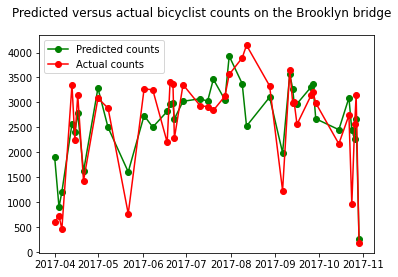

In [24]:
# Plot predicted vs actual counts
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()


In [25]:
# Both the expected value (i.e. mean) and the variance, of the Poisson
# distribution is λ. This rather strict condition is violated by most
# real-world data.